# Timeseries tutorial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
timeseries_path = os.path.join('..', 'pvops', 'timeseries')
sys.path.append('..')
sys.path.append(timeseries_path)

In [3]:
from pvops.timeseries import preprocess
from pvops.timeseries.models import linear
from pvops.text2time import utils as t2t_utils, preprocess as t2t_preprocess

In [4]:
example_OMpath = os.path.join('example_data', 'example_om_data2.csv')
example_prodpath = os.path.join('example_data', 'example_prod_with_covariates.csv')
example_metapath = os.path.join('example_data', 'example_metadata2.csv')

In [5]:
prod_data = pd.read_csv(example_prodpath, error_bad_lines=False, engine='python')

In [6]:
prod_data.head()

,date,randid,generated_kW,expected_kW,irrad_poa_Wm2,temp_amb_C,wind_speed_ms,temp_mod_C
0,2018-04-01 07:00:00,R15,0.475,0.527845,0.02775,16.570,4.2065,14.1270
1,2018-04-01 08:00:00,R15,1332.547,1685.979445,87.91450,16.998,4.1065,15.8610
2,2018-04-01 09:00:00,R15,6616.573,7343.981135,367.90350,20.168,4.5095,24.5745
3,2018-04-01 10:00:00,R15,8847.800,10429.876422,508.28700,21.987,4.9785,30.7740
4,2018-04-01 11:00:00,R15,11607.389,12981.228814,618.79450,23.417,4.6410,35.8695


In [7]:
metadata = pd.DataFrame()
metadata['randid'] = ['R15', 'R10']
metadata.head()

,randid
0,R15
1,R10


In [8]:
#Format for dictionaries is {pvops variable: user-specific column names}
prod_col_dict = {'siteid': 'randid', 
                 'timestamp': 'date', 
                 'powerprod': 'generated_kW',
                 'irradiance':'irrad_poa_Wm2',
                 'temperature':'temp_amb_C', # Optional parameter, used by one of the modeling structures
                 'baseline': 'IEC_pstep', #user's name choice for new column (baseline expected energy defined by user or calculated based on IEC)
                 'dcsize': 'dcsize', #user's name choice for new column (System DC-size, extracted from meta-data)
                 'compared': 'Compared',#user's name choice for new column
                 'energy_pstep': 'Energy_pstep'} #user's name choice for new column

metad_col_dict = {'siteid': 'randid'}

### Data Formatting

In [9]:
prod_data_converted = t2t_preprocess.prod_date_convert(prod_data, prod_col_dict)
prod_data_datena_d, _ = t2t_preprocess.prod_nadate_process(prod_data_converted, prod_col_dict, pnadrop=True)

In [10]:
prod_data_datena_d.index = prod_data_datena_d[prod_col_dict['timestamp']]

min(prod_data_datena_d.index), max(prod_data_datena_d.index)

(Timestamp('2018-04-01 07:00:00'), Timestamp('2019-03-31 18:00:00'))

### Data Preprocessing

In [11]:
masked_prod_data = preprocess.prod_inverter_clipping_filter(prod_data_datena_d, prod_col_dict, metadata, metad_col_dict, 'threshold', freq=60)

filtered_prod_data = masked_prod_data[masked_prod_data['mask'] == False]

print(f"Detected and removed {sum(masked_prod_data['mask'])} rows with inverter clipping.")

Detected and removed 24 rows with inverter clipping.


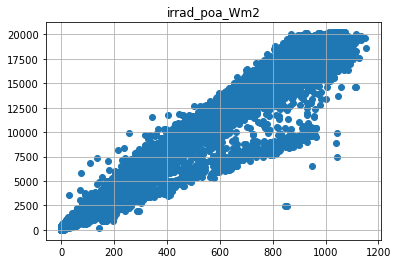

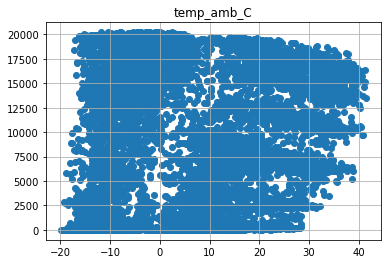

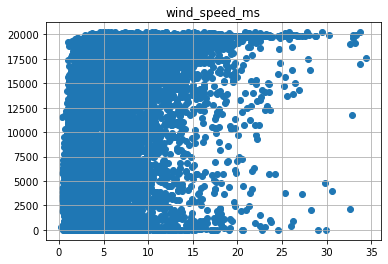

In [12]:
for xcol in ['irrad_poa_Wm2', 'temp_amb_C', 'wind_speed_ms']:
    plt.scatter(filtered_prod_data[xcol], filtered_prod_data[prod_col_dict['powerprod']])
    plt.title(xcol)
    plt.grid()
    plt.show()

### Dynamic linear modeling

In [19]:
model_prod_data = filtered_prod_data.dropna(subset=['irrad_poa_Wm2', 'temp_amb_C', 'wind_speed_ms']+[prod_col_dict['powerprod']])
model_prod_data = model_prod_data[model_prod_data['randid'] == 'R15']

# Make sure to only pass data for one site! If sites are very similar, you can consider providing both sites.
model, train_df, test_df = linear.modeller(model_prod_data,
                                            prod_col_dict,
                                            kernel_type='default',
                                            time_weighted='month',
                                            X_parameters=['irrad_poa_Wm2', 'temp_amb_C'],#, 'wind_speed_ms'],
                                            Y_parameter='generated_kW',
                                            test_split=0.05,
                                            degree=3,
                                            verbose=1)

train {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
test {3}

Begin training.
[OLS] Mean squared error: 758358.67
[OLS] Coefficient of determination: 0.98
[OLS] 24 coefficient trained.

Begin testing.
[OLS] Mean squared error: 416132.24
[OLS] Coefficient of determination: 0.99
[OLS] 24 coefficient trained.


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

def plot(model, prod_col_dict, data_split='test', npts=50):

    def print_info(real,pred,name):
        mse = mean_squared_error(real, pred)
        r2 = r2_score(real, pred)
        print(f'[{name}] Mean squared error: %.2f'
                % mse)
        print(f'[{name}] Coefficient of determination: %.2f'
                % r2)

    fig,(ax) = plt.subplots(figsize=(14,8))

    if data_split == 'test':
        df = test_df
    elif data_split == 'train':
        df = train_df

    measured = model.estimators['OLS'][f'{data_split}_y'][:npts]

    ax2 = ax.twinx()
    ax2.plot(model.estimators['OLS'][f'{data_split}_index'][:npts], df[prod_col_dict['irradiance']].values[:npts], 'k', label='irradiance')

    ax.plot(model.estimators['OLS'][f'{data_split}_index'][:npts], df['expected_kW'].values[:npts], label='partner_expected')
    print_info(measured, df['expected_kW'].values[:npts], 'partner_expected')

    ax.plot(model.estimators['OLS'][f'{data_split}_index'][:npts], measured, label='measured')
    for name, info in model.estimators.items():
        predicted = model.estimators[name][f'{data_split}_prediction'][:npts]
        ax.plot(model.estimators[name][f'{data_split}_index'][:npts], predicted, label=name)
        print_info(measured, predicted, name)

    ax2.set_ylabel("Irradiance (W/m2)")
    ax.set_ylabel("Power (W)")
    ax.set_xlabel('Time')
    handles, labels = [(a+b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
    ax.legend(handles, labels, loc='best')
    plt.show()


### Observe performance

[partner_expected] Mean squared error: 2883252.79
[partner_expected] Coefficient of determination: 0.93
[OLS] Mean squared error: 293335.86
[OLS] Coefficient of determination: 0.99
[RANSAC] Mean squared error: 292937.15
[RANSAC] Coefficient of determination: 0.99


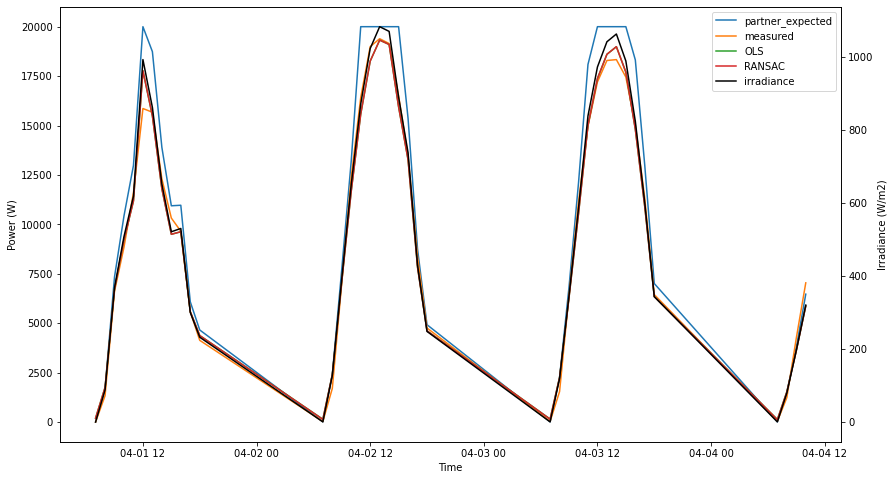

In [15]:
plot(model, prod_col_dict, data_split='train', npts=40)

[partner_expected] Mean squared error: 168126.54
[partner_expected] Coefficient of determination: 1.00
[OLS] Mean squared error: 346204.48
[OLS] Coefficient of determination: 0.99
[RANSAC] Mean squared error: 361557.64
[RANSAC] Coefficient of determination: 0.99


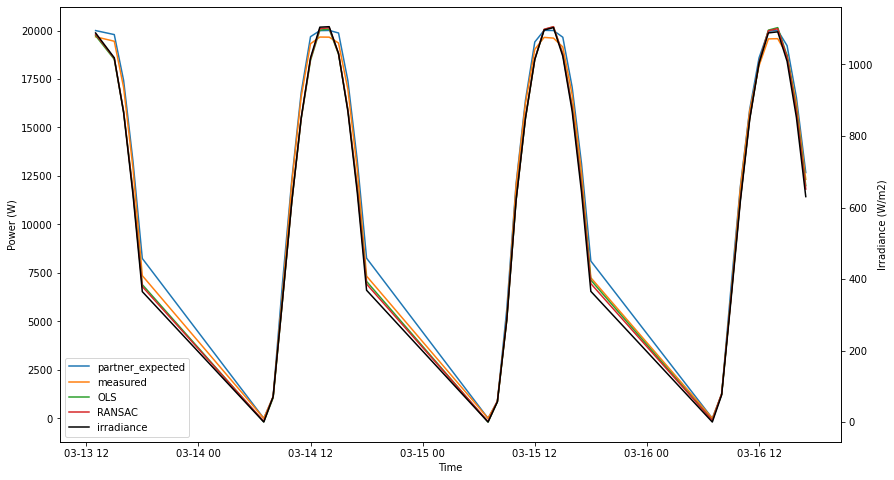

In [16]:
plot(model, prod_col_dict, data_split='test', npts=40)